In [1]:
from pyomo.environ import *
import numpy as np
import qiskit
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.primitives import Sampler
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.optimizers import COBYLA
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit.circuit.library import QAOAAnsatz
from scipy.optimize import minimize
from qiskit.visualization import plot_distribution

### Problem

$$\text{Maximize } z = 20x_1 + 40x_2 + 20x_3 + 15x_4 + 30x_5$$

#### Restrictions

Year 1:  $ 5x_1 + 4x_2 + 3x_3 + 7x_4 + 8x_5 \leq 25$

Year 2:  $ 5x_1 + 7x_2 + 9x_3 + 4x_4 + 6x_5 \leq 25$

Year 3:  $ 8x_1 + 10x_2 + 2x_3 + 3x_4 + 10x_5 \leq 25$



In [2]:
project_selection_model = ConcreteModel()

#Problem data definition:
projects = [1, 2, 3, 4, 5]
returns = {1: 20, 2: 40, 3: 20, 4: 15, 5: 30}
cost = {
    1: [5, 5, 8],
    2: [4, 7, 10],
    3: [3, 9, 2],
    4: [7, 4, 3],
    5: [8, 6, 10]
}

annual_budget = [25, 25, 25]

#Decision variables
project_selection_model.x = Var(projects, within=Binary)

#OBJECTIVE FUNCTION: maximize total return
project_selection_model.obj = Objective(
    expr=sum(returns[j] * project_selection_model.x[j] for j in projects),
    sense=maximize
)


In [3]:
#Applying the restrictions
project_selection_model.ano1_constraint = Constraint(
    expr=sum(cost[j][0] * project_selection_model.x[j] for j in projects) <= annual_budget[0]
)
project_selection_model.ano2_constraint = Constraint(
    expr=sum(cost[j][1] * project_selection_model.x[j] for j in projects) <= annual_budget[1]
)
project_selection_model.y3_constraint = Constraint(
    expr=sum(cost[j][2] * project_selection_model.x[j] for j in projects) <= annual_budget[2]
)

In [4]:
solver = SolverFactory('glpk')
result = solver.solve(project_selection_model)

print("Optimization Status:", result.solver.status)
print("Solution Status:", result.solver.termination_condition)

print("\nSelected Projects:")
for j in projects:
    if project_selection_model.x[j].value == 1:
        print(f"Project {j}: Selected")

print("\nTotal Return:", project_selection_model.obj())

Optimization Status: ok
Solution Status: optimal

Selected Projects:
Project 1: Selected
Project 2: Selected
Project 3: Selected
Project 4: Selected

Total Return: 95.0


### Transcrevendo o problema para o tipo QUBO:

$$
\min_{x \in \{0,1\}^n} -\mu^T x + \alpha (1^T x - B)^2
$$


In [26]:
mu = [20, 40, 20, 15, 30] # Expected returns from each project
alpha = 1 # Penalty 
n = len(mu) # Number of projects

In [27]:
cov_matrix = np.zeros((n, n))

print(cov_matrix)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [28]:
projectSelectionQP = QuadraticProgram("Project Selection")

print(projectSelectionQP.prettyprint())

Problem name: Project Selection

Minimize
  0

Subject to
  No constraints

  No variables



In [29]:
for i in range(n):
    projectSelectionQP.binary_var(name=f'x{i}')

In [30]:
linear = [-mu[i] for i in range(n)]
linear

[-20, -40, -20, -15, -30]

In [31]:
quadratic = {(f'x{i}', f'x{j}'): 0 for i in range(n) for j in range(i, n)}
quadratic

{('x0', 'x0'): 0,
 ('x0', 'x1'): 0,
 ('x0', 'x2'): 0,
 ('x0', 'x3'): 0,
 ('x0', 'x4'): 0,
 ('x1', 'x1'): 0,
 ('x1', 'x2'): 0,
 ('x1', 'x3'): 0,
 ('x1', 'x4'): 0,
 ('x2', 'x2'): 0,
 ('x2', 'x3'): 0,
 ('x2', 'x4'): 0,
 ('x3', 'x3'): 0,
 ('x3', 'x4'): 0,
 ('x4', 'x4'): 0}

In [32]:
projectSelectionQP.minimize(constant=0, linear=dict(zip([f'x{i}' for i in range(n)], linear)), quadratic=quadratic)

projectSelectionQP.linear_constraint(
    linear={'x0': 5, 'x1': 4, 'x2': 3, 'x3': 7, 'x4': 8},
    sense='<=',
    rhs=25
)

projectSelectionQP.linear_constraint(
    linear={'x0': 5, 'x1': 7, 'x2': 9, 'x3': 4, 'x4': 6},
    sense='<=',
    rhs=25
)

projectSelectionQP.linear_constraint(
    linear={'x0': 8, 'x1': 10, 'x2': 2, 'x3': 3, 'x4': 10},
    sense='<=',
    rhs=25
)

print(projectSelectionQP.prettyprint())

Problem name: Project Selection

Minimize
  -20*x0 - 40*x1 - 20*x2 - 15*x3 - 30*x4

Subject to
  Linear constraints (3)
    5*x0 + 4*x1 + 3*x2 + 7*x3 + 8*x4 <= 25  'c0'
    5*x0 + 7*x1 + 9*x2 + 4*x3 + 6*x4 <= 25  'c1'
    8*x0 + 10*x1 + 2*x2 + 3*x3 + 10*x4 <= 25  'c2'

  Binary variables (5)
    x0 x1 x2 x3 x4



In [33]:
exact_mes = NumPyMinimumEigensolver()
exact_optimizer = MinimumEigenOptimizer(exact_mes)
exact_result = exact_optimizer.solve(projectSelectionQP)

print(exact_result.prettyprint())

objective function value: -95.0
variable values: x0=1.0, x1=1.0, x2=1.0, x3=1.0, x4=0.0
status: SUCCESS


In [10]:
aer_sim = AerSimulator()

algorithm_globals.random_seed = 10598
sampler = Sampler(backend=aer_sim)
qaoa_mes = QAOA(sampler=sampler, optimizer=COBYLA(), initial_point=[0.0, 0.0])

/tmp/ipykernel_50845/1994804795.py:4: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=aer_sim)


In [12]:
qaoa_optimizer = MinimumEigenOptimizer(qaoa_mes)
qaoa_result = exact_optimizer.solve(projectSelectionQP)

print(qaoa_result.prettyprint())

objective function value: -95.0
variable values: x0=1.0, x1=1.0, x2=1.0, x3=1.0, x4=0.0
status: SUCCESS


### Hamiltonian and QAOA circuit

In [45]:
constraints = [
    [5, 4, 3, 7, 8],  # restriction 1
    [5, 7, 9, 4, 6],  # restriction 2
    [8, 10, 2, 3, 10],  # restriction 3
]

rhs = [25, 25, 25]

In [46]:
projectSelectionQP = QuadraticProgram("Project Selection")

for i in range(n):
    projectSelectionQP.binary_var(name=f'x{i}')

linear = [-mu[i] for i in range(n)]
projectSelectionQP.minimize(linear=dict(zip([f'x{i}' for i in range(n)], linear)))

#### Reformulation of restriction to penalty

- **Current restriction:** $c_1x_1 + c_2x_2 + \dots + c_nx_n \leq b$

- **Penalty term on target:** 
$
\alpha \cdot \left(\max(0, c_1x_1 + c_2x_2 + \dots + c_nx_n - b)\right)^2
$


In [47]:
for k, (constraint, limit) in enumerate(zip(constraints, rhs)):

    penalty = {f'x{i}': coef for i, coef in enumerate(constraint)}
    

    projectSelectionQP.minimize(
        quadratic={(f'x{i}', f'x{j}'): alpha * penalty[f'x{i}'] * penalty[f'x{j}']
                   for i in range(n) for j in range(n)},
        linear={f'x{i}': -2 * alpha * limit * penalty[f'x{i}'] for i in range(n)},
        constant=alpha * limit**2
    )

In [48]:
qubo = QuadraticProgramToQubo().convert(projectSelectionQP)

print(qubo.prettyprint())

Problem name: Project Selection

Minimize
  64*x0^2 + 160*x0*x1 + 32*x0*x2 + 48*x0*x3 + 160*x0*x4 + 100*x1^2 + 40*x1*x2
  + 60*x1*x3 + 200*x1*x4 + 4*x2^2 + 12*x2*x3 + 40*x2*x4 + 9*x3^2 + 60*x3*x4
  + 100*x4^2 - 400*x0 - 500*x1 - 100*x2 - 150*x3 - 500*x4 + 625

Subject to
  No constraints

  Binary variables (5)
    x0 x1 x2 x3 x4



In [49]:
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)

In [50]:
hamiltonian, offset = qubo.to_ising()

In [61]:
ansatz = QAOAAnsatz(hamiltonian, reps=6)

ansatz_isa = pm.run(ansatz)
hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)

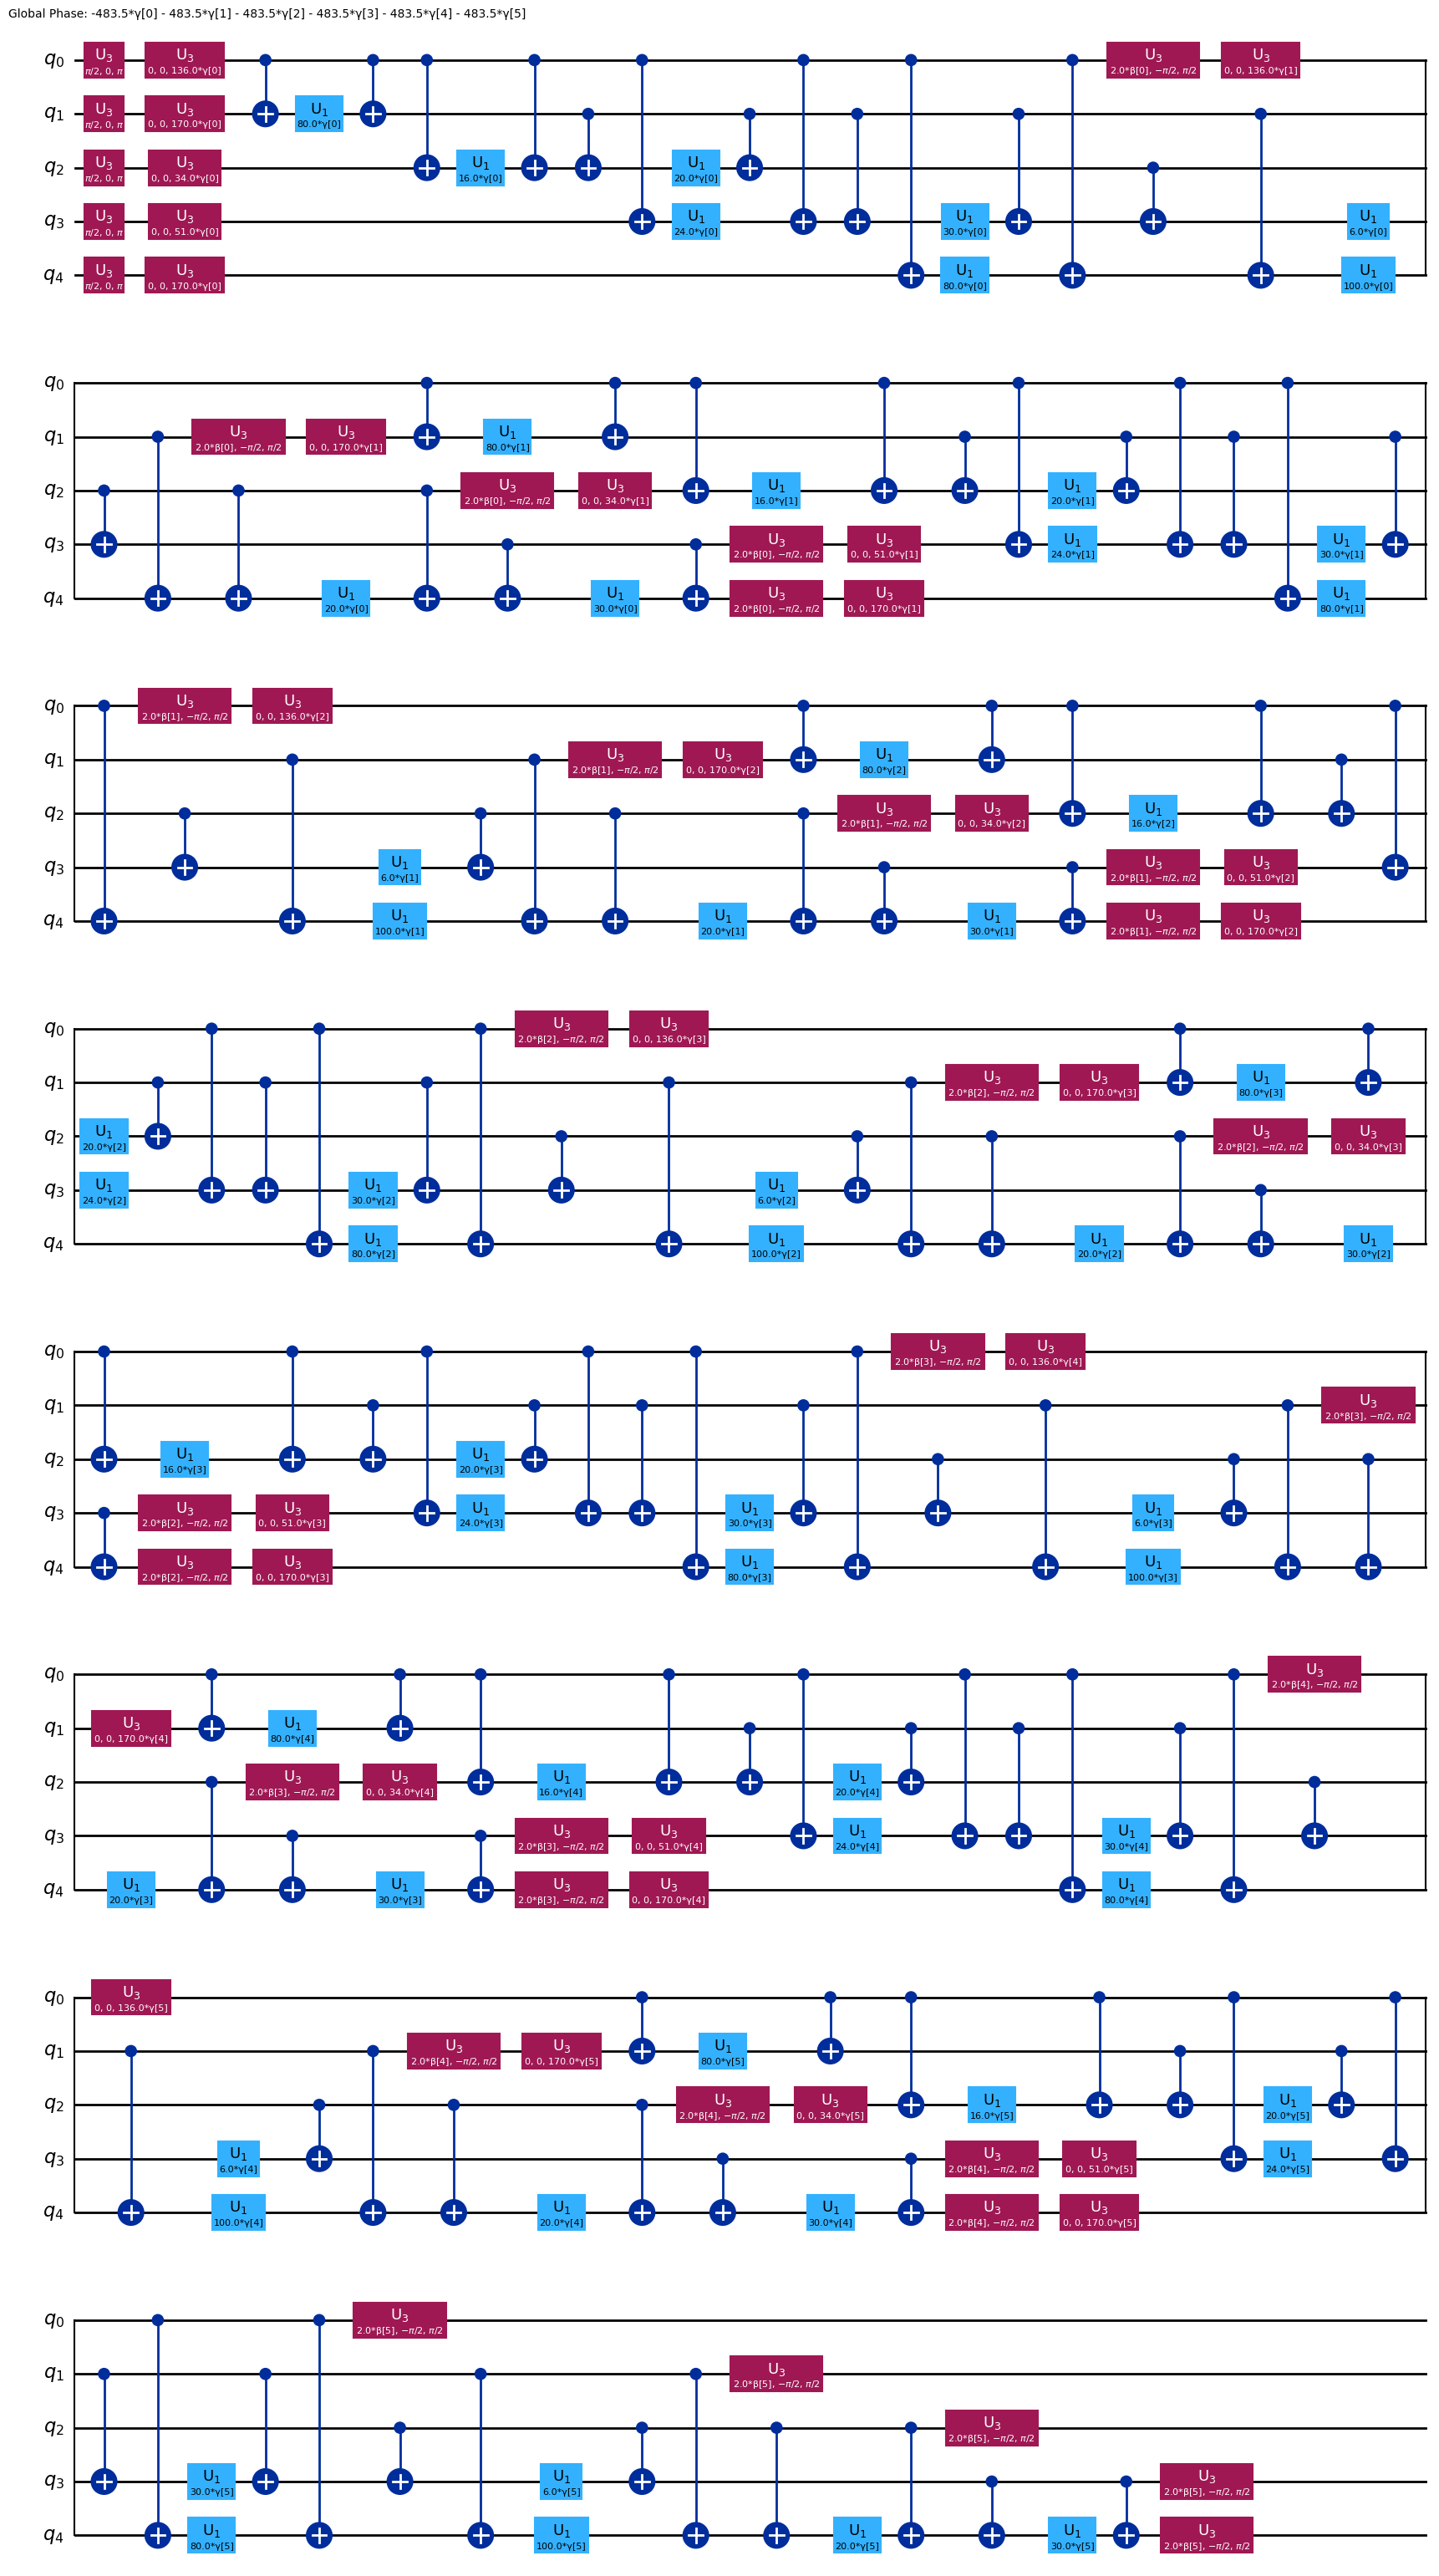

In [41]:
ansatz_isa.decompose(reps=2).draw(output="mpl", style="iqp")

In [20]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    cost = result[0].data.evs[0]

    return cost

In [51]:
def run_experiment(n_range, p, shots_estimator, shots_sampler):

    ansatz = QAOAAnsatz(hamiltonian, reps=p)
    ansatz_isa = pm.run(ansatz)
    hamiltonian_isa = hamiltonian.apply_layout(ansatz_isa.layout)

    estimator = Estimator(backend=aer_sim)
    estimator.options.default_shots = shots_estimator
    estimator.options.dynamical_decoupling.enable = True

    sampler = Sampler(backend=aer_sim)
    sampler.options.default_shots = shots_sampler
    sampler.options.dynamical_decoupling.enable = True
    
    x0 = 2 * np.pi * np.random.rand(ansatz_isa.num_parameters)
    
    results = []
    
    for n in range(n_range):

        res = minimize(cost_func, x0, args=(ansatz_isa, hamiltonian_isa, estimator), method="COBYLA")
    
        qc = ansatz_isa.assign_parameters(res.x)
        qc.measure_all()
        qc_isa = pm.run(qc)

        result = sampler.run([qc_isa]).result()
        
        samp_dist = result[0].data.meas.get_counts()
        most_probable_state = max(samp_dist, key=samp_dist.get)
        results.append(most_probable_state)
    
    return results


In [58]:
results = run_experiment(15, 6, 5000, 5000)

/tmp/ipykernel_50845/3799457588.py:7: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(backend=aer_sim)
/tmp/ipykernel_50845/3799457588.py:11: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  sampler = Sampler(backend=aer_sim)
/home/anna/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decoupling': {'enable': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/home/anna/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:232: UserWarning: Options {'dynamical_decouplin

In [59]:
print(results)

['10011', '11110', '10110', '11010', '11110', '11110', '10011', '11011', '10010', '10001', '01111', '11011', '10111', '01101', '11011']


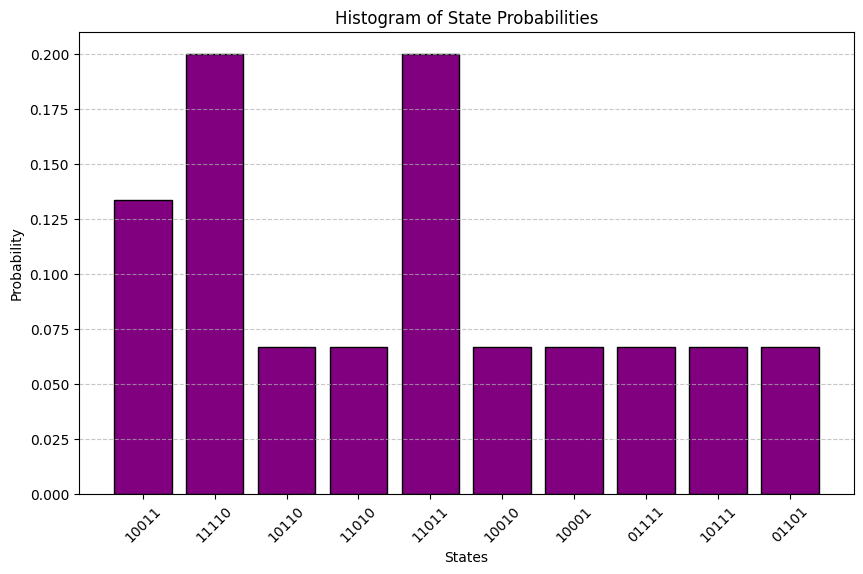

In [60]:
import matplotlib.pyplot as plt
from collections import Counter

state_counts = Counter(results)
total_counts = sum(state_counts.values())

state_probabilities = {state: count / total_counts for state, count in state_counts.items()}

plt.figure(figsize=(10, 6))
plt.bar(state_probabilities.keys(), state_probabilities.values(), color='purple', edgecolor='black')
plt.xlabel('States')
plt.ylabel('Probability')
plt.title('Histogram of State Probabilities')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
